<a href="https://colab.research.google.com/github/buseskorkmaz/Sentiment-Analysis-with-Deep-Learning/blob/main/machine_learning_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install wget
#!pip install nltk
#!pip install lime
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
np.random.seed(0)
from keras.models import Model
from sklearn.model_selection import train_test_split
import wget
np.random.seed(2)
import seaborn as sns
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection,metrics
## for explainer
from lime import lime_text
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

url = "https://sagemaker-eu-west-1-935545223210.s3-eu-west-1.amazonaws.com/reuters_result_scored.csv"

file_input = wget.download(url)

dtf =  pd.read_csv(file_input)
print(dtf.sample(5))

                                                  name  ... score
257  Oil collected from Brazil's northeastern coast...  ...    -1
678  Saudi Arabia to wait for investigation before ...  ...     0
185  U.S. shipping sanctions deal European refiners...  ...     1
423  Bernie Sanders 'up and about,' will be in next...  ...     1
823  Too soon to say if U.S. emergency oil release ...  ...    -1

[5 rows x 4 columns]


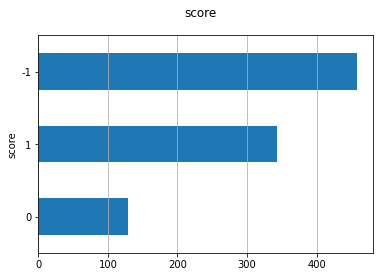

                                                name  ...                                         text_clean
0  Oil steadies as traders eye U.S.-China talks, ...  ...  oil steadi trader eye uschina talk inventori d...
1  Companies slow to disclose financial costs of ...  ...  compani slow disclos financi cost climat chang...
2  Brazil's Bolsonaro suggests oil spill could be...  ...  brazil bolsonaro suggest oil spill could attem...
3  Trump: U.S. troops won't immediately return fr...  ...  trump us troop wont immedi return syria ceasef...
4  Maersk lifts 2019 profit forecast, shares rise...  ...  maersk lift 2019 profit forecast share rise 7 ...

[5 rows x 6 columns]
# -1:
  . selected features: 715
  . top features: protest,kill,chevron,shell,billion,baghdad,fell,iraq,forc,total
 
# 0:
  . selected features: 1023
  . top features: democrat,hous,impeach,oil,presidenti,trump,investig,biden,washington,presid donald trump
 
# 1:
  . selected features: 867
  . top features: billion,trump,s

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("score", fontsize=12)
dtf["score"].reset_index().groupby("score").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

lst_stopwords = nltk.corpus.stopwords.words("english")

def proc(s):
    l = s.split()
    return ' '.join(l[:55])

dtf["text_c"] = [proc(s) for s in dtf["text"].values.tolist()]


dtf["text_clean"] = (dtf["name"] +" "+ dtf["text_c"]).apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=True, flg_lemm=False, 
          lst_stopwords=lst_stopwords))

print(dtf.head())

dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3, random_state=42)
y_train = dtf_train["score"].values
y_test = dtf_test["score"].values

## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,3))

## Tf-Idf (advanced variant of BoW)
#vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,3))

corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

y = dtf_train["score"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "p-score":1-p, "score":cat}))
    dtf_features = dtf_features.sort_values(["score","p-score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["p-score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()


for cat in np.unique(y):
    print("# {}:".format(cat))
    print("  . selected features:",
         len(dtf_features[dtf_features["score"]==cat]))
    print("  . top features:", ",".join(dtf_features[dtf_features["score"]==cat]["feature"].values[:10]))
    print(" ")

    
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

def predict(X_train, y_train, y_test, classifier=MLPClassifier(alpha=1, max_iter=50), name="Neural Net"):
    print('---------------Prediction with '+name+ '---------------------------')
    ## pipeline
    model = pipeline.Pipeline([("vectorizer", vectorizer), ("classifier", classifier)])
    model["classifier"].fit(X_train, y_train)
    ## test
    X_test = dtf_test["text_clean"].values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)

    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values

    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))

    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2)

    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic: \n" + name)
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
    
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve:\n " + name)
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return predicted, predicted_prob, model

---------------Prediction with Nearest Neighbors---------------------------
Accuracy: 0.54
Auc: 0.69
Detail:
              precision    recall  f1-score   support

          -1       0.53      0.72      0.61       130
           0       0.57      0.29      0.38        45
           1       0.57      0.44      0.50       104

    accuracy                           0.54       279
   macro avg       0.55      0.48      0.50       279
weighted avg       0.55      0.54      0.53       279



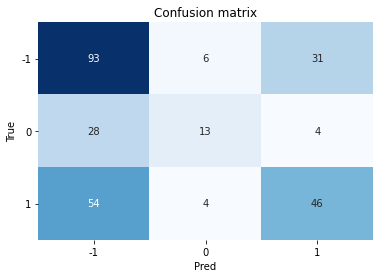

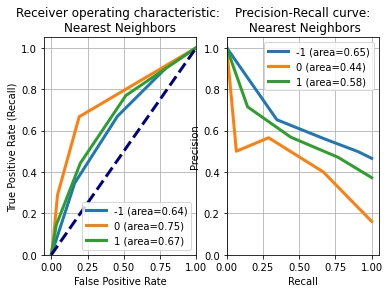

---------------Prediction with Decision Tree---------------------------
Accuracy: 0.46
Auc: 0.62
Detail:
              precision    recall  f1-score   support

          -1       0.47      0.35      0.40       130
           0       0.52      0.31      0.39        45
           1       0.44      0.65      0.52       104

    accuracy                           0.46       279
   macro avg       0.47      0.44      0.44       279
weighted avg       0.46      0.46      0.44       279



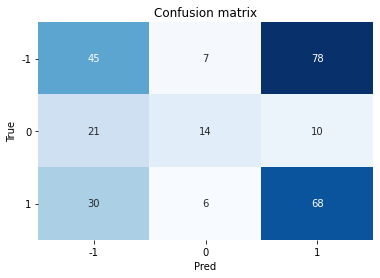

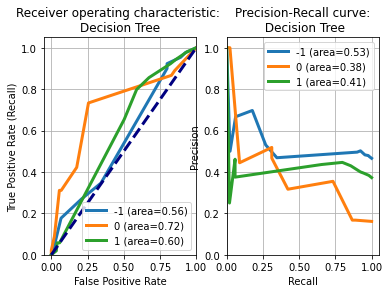

---------------Prediction with Random Forest---------------------------
Accuracy: 0.48
Auc: 0.64
Detail:
              precision    recall  f1-score   support

          -1       0.47      0.98      0.64       130
           0       0.00      0.00      0.00        45
           1       0.75      0.06      0.11       104

    accuracy                           0.48       279
   macro avg       0.41      0.35      0.25       279
weighted avg       0.50      0.48      0.34       279



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


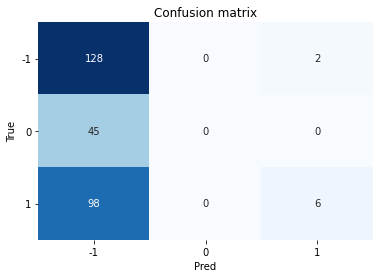

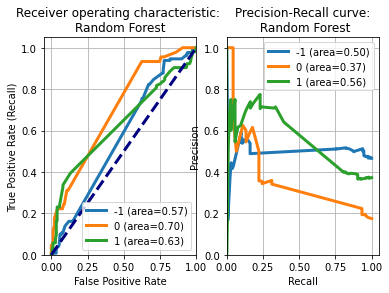

---------------Prediction with Neural Net---------------------------
Accuracy: 0.61
Auc: 0.8
Detail:
              precision    recall  f1-score   support

          -1       0.59      0.73      0.65       130
           0       0.58      0.42      0.49        45
           1       0.65      0.53      0.59       104

    accuracy                           0.61       279
   macro avg       0.61      0.56      0.57       279
weighted avg       0.61      0.61      0.60       279



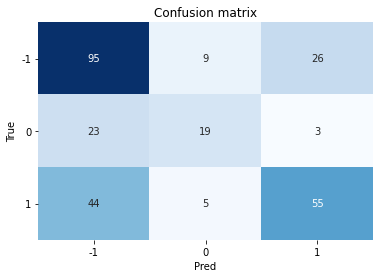

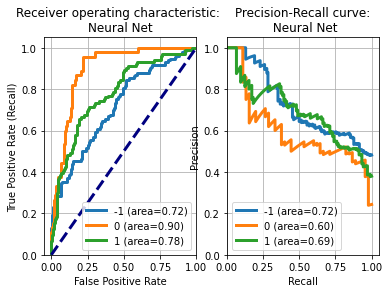

---------------Prediction with AdaBoost---------------------------
Accuracy: 0.57
Auc: 0.71
Detail:
              precision    recall  f1-score   support

          -1       0.57      0.65      0.61       130
           0       0.53      0.40      0.46        45
           1       0.57      0.54      0.55       104

    accuracy                           0.57       279
   macro avg       0.56      0.53      0.54       279
weighted avg       0.56      0.57      0.56       279



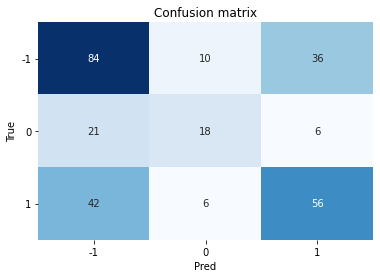

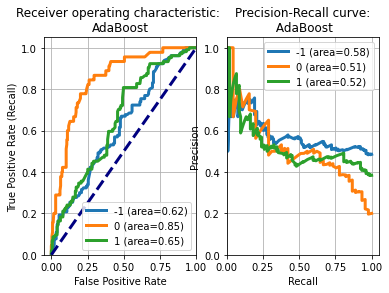

---------------Prediction with Naive Bayes---------------------------
Accuracy: 0.57
Auc: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.52      0.92      0.66       130
           0       0.00      0.00      0.00        45
           1       0.78      0.38      0.51       104

    accuracy                           0.57       279
   macro avg       0.43      0.43      0.39       279
weighted avg       0.53      0.57      0.50       279



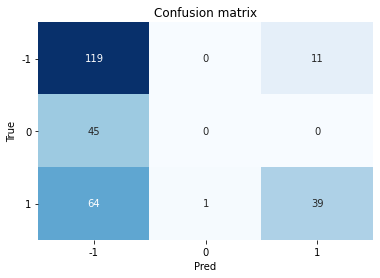

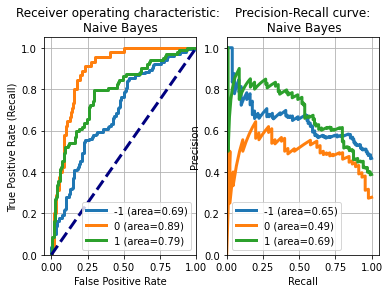

In [ ]:
df_classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    naive_bayes.MultinomialNB()]

names = ["Nearest Neighbors", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]


## train classifier
for name, classifier in zip(names, df_classifiers):
    predict(X_train, y_train, y_test, classifier, name)

---------------Prediction with Neural Net---------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.62
Auc: 0.8
Detail:
              precision    recall  f1-score   support

          -1       0.58      0.81      0.68       130
           0       0.70      0.31      0.43        45
           1       0.69      0.52      0.59       104

    accuracy                           0.62       279
   macro avg       0.66      0.55      0.57       279
weighted avg       0.64      0.62      0.61       279



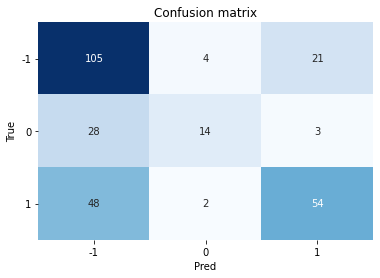

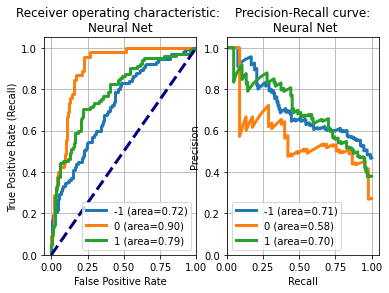

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


True: 1 --> Pred: 1 | Prob: 0.72


In [ ]:
predicted, predicted_prob, model = predict(X_train, y_train, y_test)
## select observation
i = 94
dtf_test["combine"] = dtf_test["text"] + " "  +dtf["name"]
txt_instance = dtf_test["combine"].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explained = explainer.explain_instance(txt_instance, model.predict_proba, num_features=10)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

In [ ]:
dtf_features

,feature,p-score,score
5355,protest,0.999999,-1
3696,kill,0.999997,-1
1223,chevron,0.999993,-1
8432,shell,0.999992,-1
872,billion,0.999975,-1
...,...,...,...
4747,oil product,0.951262,1
9119,top,0.951262,1
2828,fuel,0.950677,1
4524,north,0.950159,1
